In [1]:
using Turing, Flux, Plots, Random, ReverseDiff
Turing.setprogress!(false);
Turing.setadbackend(:reversediff)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing C:\Users\XudongT\.julia\packages\Turing\S4Y4B\src\Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI C:\Users\XudongT\.julia\packages\AdvancedVI\W2zsz\src\AdvancedVI.jl:15


:reversediff

In [2]:
# total number of data points
N = 80
M = round(Int, N / 4)

# generate data points for label 1
Random.seed!(1234)
x1s = rand(M) * 4.5
x2s = rand(M) * 4.5
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i in 1:M])
x1s = rand(M) * 4.5;
x2s = rand(M) * 4.5;
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i in 1:M]))

# generate data points for label 0
x1s = rand(M) * 4.5;
x2s = rand(M) * 4.5;
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i in 1:M])
x1s = rand(M) * 4.5;
x2s = rand(M) * 4.5;
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i in 1:M]));

In [6]:
# concatnate all data points
xs = [xt1s; xt0s]
# create a balanced label design
ts = [ones(2 * M); zeros(2 * M)];
# 80 samples, 2 predicters for each sample

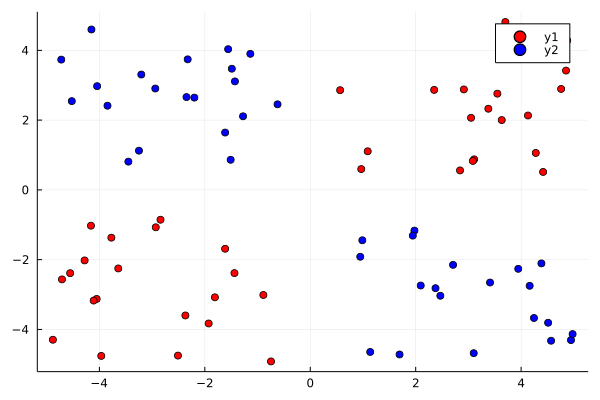

In [7]:
# plot the data points
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)

    Plots.scatter(x1, y1; color="red", clim=(0, 1))
    return Plots.scatter!(x2, y2; color="blue", clim=(0, 1))
end

plot_data()

In [8]:
# construct the nn
nn_initial = Chain(Dense(2, 3, tanh), Dense(3, 2, tanh), Dense(2, 1, σ))

Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  Dense(3 => 2, tanh),                  # 8 parameters
  Dense(2 => 1, σ),                     # 3 parameters
)                   # Total: 6 arrays, 20 parameters, 464 bytes.

In [10]:
# extract the parameters by destructure()
# reconstruct is a function that update new parameters and put them back into the original NN
parameters_initial, reconstruct = Flux.destructure(nn_initial);
# number of parameters in the original nn
length(parameters_initial)

20

In [13]:
# now create a parameter variable that has IID Gaussian Distribution
alpha = 0.09
# variance for the gaussian prior
sig = sqrt(1.0 / alpha)

# Specify the probabilistic model.
@model function bayes_nn(xs, ts, nparameters, reconstruct)
    # Create the weight and bias vector.
    parameters ~ MvNormal(zeros(nparameters), sig .* ones(nparameters))

    # Construct NN from parameters
    nn = reconstruct(parameters)
    # Forward NN to make predictions
    preds = nn(xs)

    # Observe each prediction.
    for i in 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end

bayes_nn (generic function with 2 methods)

In [14]:
# Perform inference.
N = 5000
ch = sample(
    bayes_nn(hcat(xs...), ts, length(parameters_initial), reconstruct), HMC(0.05, 4), N
)

Chains MCMC chain (5000×29×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 90.2 seconds
Compute duration  = 90.2 seconds
parameters        = parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], parameters[6], parameters[7], parameters[8], parameters[9], parameters[10], parameters[11], parameters[12], parameters[13], parameters[14], parameters[15], parameters[16], parameters[17], parameters[18], parameters[19], parameters[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
      parameters      mean       std   naive_se      mcse       ess      rhat  ⋯
          Symbol   Float64   Float64    Float64   Float64   Float64   Float64  ⋯

   parameters[1]   -0.1862    0.7984     0.0113    0.0800   50.5708    1.0007  ⋯
   parameters[2]    1.9289    2.1161     0.0299    0.2441   12.8514  

In [17]:
theta = MCMCChains.group(ch, :parameters).value;

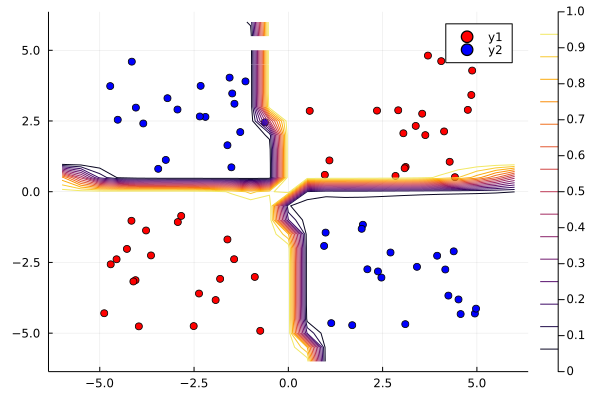

In [27]:
# A helper to create NN from weights `theta` and run it through data `x`
nn_forward(x, theta) = reconstruct(theta)(x)

# Plot the data we have.
plot_data()
# Find the index that provided the highest log posterior in the chain.
_, i = findmax(ch[:lp])
# Extract the max row value from i.
i = i.I[1]

# Plot the posterior distribution with a contour plot
x1_range = collect(range(-6; stop=6, length=25))
x2_range = collect(range(-6; stop=6, length=25))
Z = [nn_forward([x1, x2], theta[i, :])[1] for x1 in x1_range, x2 in x2_range]
contour!(x1_range, x2_range, Z)

In [28]:
# Return the average predicted value across
# multiple weights.
function nn_predict(x, theta, num)
    return mean([nn_forward(x, theta[i, :])[1] for i in 1:10:num])
end;

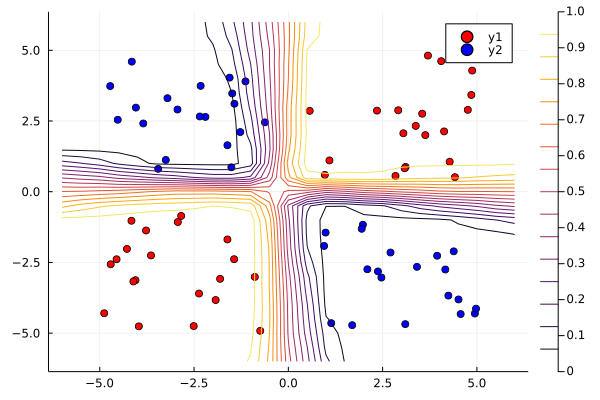

In [29]:
# Plot the average prediction.
plot_data()

n_end = 1500
x1_range = collect(range(-6; stop=6, length=25))
x2_range = collect(range(-6; stop=6, length=25))
Z = [nn_predict([x1, x2], theta, n_end)[1] for x1 in x1_range, x2 in x2_range]
contour!(x1_range, x2_range, Z)